# **Pneumonia Detection Using ResNet**
Author: chan030609 <br><br>
<img src = 'https://images.emedicinehealth.com/images/article/main_image/bacterial-pneumonia-1.jpg' width="400">
<br><br>
In this project, the model will detect pneumonia by using x-ray images as the input of ResNet Convolutional Neural Network model.

In [1]:
from google.colab import drive
drive.mount('/content/drive/') # for Google Colab

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Importing Libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import os

## Data Augmentation

In [3]:
data_dir = '/content/drive/My Drive/Colab Notebooks/chest-array/'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "train")
print(classes)

['test', 'train']
['NORMAL', 'PNEUMONIA']


In [4]:
pneumonia_files = os.listdir(data_dir + "train/PNEUMONIA")
print('No. of training examples for Pneumonia:', len(pneumonia_files))
normal_files = os.listdir(data_dir + "train/NORMAL")
print('No. of training examples for Normal:', len(normal_files))

No. of training examples for Pneumonia: 3875
No. of training examples for Normal: 1341


In [5]:
dataset = ImageFolder(data_dir+'train', transform=tt.Compose([tt.Resize(255),
                                                              tt.CenterCrop(224),
                                                              tt.RandomHorizontalFlip(),
                                                              tt.RandomRotation(10),
                                                              tt.RandomGrayscale(),
                                                              tt.RandomAffine(translate=(0.05, 0.05), degrees=0),
                                                              tt.ToTensor(),
                                                              tt.Normalize(mean=[0.485, 0.456, 0.406],
                                                                           std=[0.229, 0.224, 0.225],
                                                                           inplace=True)
                                                              ]))

dataset

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: /content/drive/My Drive/Colab Notebooks/chest-array/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], resample=False, expand=False)
               RandomGrayscale(p=0.1)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
img, label = dataset[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 0


After transformation, images are expressed as 224 pixels by 224 pixels with RGB colors.

In [7]:
def plot_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols =5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

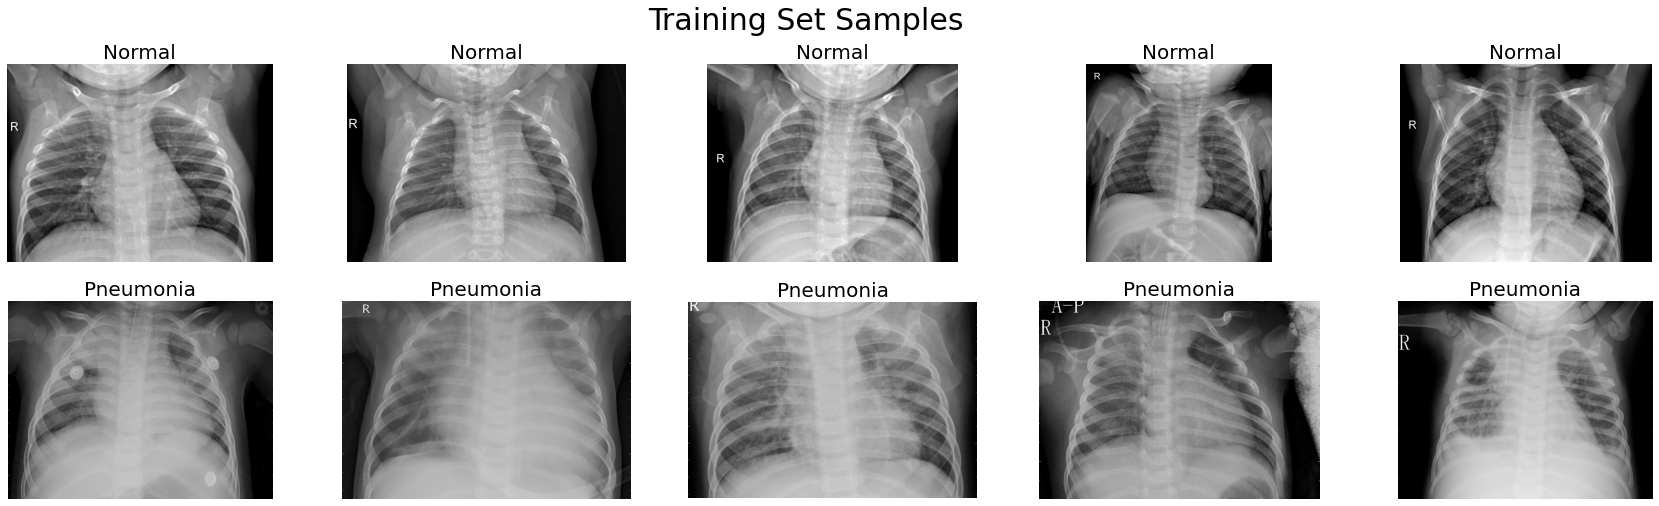

In [8]:
rand_samples = random.sample([os.path.join(data_dir+'/train/NORMAL', filename) 
                              for filename in os.listdir(data_dir+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(data_dir+'/train/PNEUMONIA')], 5)
plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

The difference between normal x-rays and pneumonia x-rays is invisible to the naked eye.

## Train, Validation, Test Data

In [9]:
# delete this portion for a different result
random_seed = 2021
torch.manual_seed(random_seed);

For greater accuracy, a validation set, 30% of the original training data, was separated from the training set.

In [10]:
train_size = round(len(dataset)*0.7)
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3651, 1565)

In [11]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)


## GPU

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Loss and Accuracy Calculation

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [14]:
class PneumoniaModelBase(nn.Module):

    # train loss and accuracy every batch
    def training_step(self, batch, weight):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)  # generate predictions
        loss = F.cross_entropy(out, labels, weight=weight)  # weighted loss
        acc, preds = accuracy(out, labels)  # accuracy
        
        return {'train_loss': loss, 'train_acc': acc}


    # train loss and accuracy every epoch
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['train_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}


    # validation loss, accuracy, prediction, and label every batch
    def validation_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc, preds = accuracy(out, labels)
        
        return {'val_loss': loss.detach(), 'val_acc': acc.detach(), 'preds': preds.detach(), 'labels': labels.detach()}


    # validation loss and accuracy every epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    

    # training result every peoch
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}' \
              .format(epoch+1, train_result['train_loss'], train_result['train_acc'], val_result['val_loss'], val_result['val_acc']))
        

    # test loss, accuracy, prediction list, and label list every epoch
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()]
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]

        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(), 'test_preds': batch_preds, 'test_labels': batch_labels}

### ResNet50 Architecture

In [15]:
class PneumoniaResnet(PneumoniaModelBase):
    

    def __init__(self):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        for param in self.network.fc.parameters():
            param.require_grad = False
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, 2)
    

    def forward(self, xb):
        return self.network(xb)

## Helper Functions

In [16]:
@torch.no_grad()


# evaluation result
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)


# model execution
def fit(epochs, lr, model, train_loader, val_loader, weight, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache
    history = {}
    optimizer = opt_func(model.parameters(), lr)
    best_loss = 1

    for epoch in range(epochs):
        model.train()
        train_outputs = []
        lrs = []

        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']
            train_outputs.append(outputs)
            train_results = model.train_epoch_end(train_outputs)
            
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()

        val_results = evaluate(model, val_loader)
        if val_results['val_loss'] < best_loss and epoch + 1 > 15:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())

        model.epoch_end(epoch, train_results, val_results)
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                  'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'],
                  'lrs': lrs}

        for key, val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val] 
    
    model.load_state_dict(best_model_wts)

    return history, optimizer, best_loss

## Train and Evaluate Model

In [17]:
model = PneumoniaResnet().to(device)

In [18]:
epochs = 20
lr = 0.0001
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam

# weighted loss for class imbalance
weight = torch.FloatTensor([3875/(3875+1341), 1341/(3875+1341)]).to(device)

In [19]:
history, optimizer, best_loss = fit(epochs, lr, model, train_dl, val_dl, weight, grad_clip=grad_clip, opt_func=opt_func)

Epoch [1], train_loss: 0.1651, train_acc: 0.9345, val_loss: 0.0907, val_acc: 0.9611
Epoch [2], train_loss: 0.0627, train_acc: 0.9780, val_loss: 0.0468, val_acc: 0.9844
Epoch [3], train_loss: 0.0508, train_acc: 0.9809, val_loss: 0.0792, val_acc: 0.9788
Epoch [4], train_loss: 0.0351, train_acc: 0.9855, val_loss: 0.0841, val_acc: 0.9782
Epoch [5], train_loss: 0.0304, train_acc: 0.9879, val_loss: 0.0835, val_acc: 0.9727
Epoch [6], train_loss: 0.0332, train_acc: 0.9895, val_loss: 0.0665, val_acc: 0.9749
Epoch [7], train_loss: 0.0212, train_acc: 0.9919, val_loss: 0.0781, val_acc: 0.9766
Epoch [8], train_loss: 0.0388, train_acc: 0.9860, val_loss: 0.0471, val_acc: 0.9827
Epoch [9], train_loss: 0.0243, train_acc: 0.9912, val_loss: 0.0775, val_acc: 0.9788
Epoch [10], train_loss: 0.0119, train_acc: 0.9965, val_loss: 0.0675, val_acc: 0.9821
Epoch [11], train_loss: 0.0075, train_acc: 0.9973, val_loss: 0.0506, val_acc: 0.9833
Epoch [12], train_loss: 0.0130, train_acc: 0.9954, val_loss: 0.0511, val_a

In [20]:
print('Best loss is: ', best_loss)

Best loss is:  0.050678715109825134


In [21]:
bestmodel = {'model': PneumoniaResnet(),
             'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict()}

# saves model for later use
torch.save(bestmodel, 'PneumoniaRestnet.pth')

In [22]:
# Use: model = load_checkpoint('./PneumoniaResnet.pth')
#       if the saved chekcpoint is to be loaded

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

## Plot Accuracy and Loss

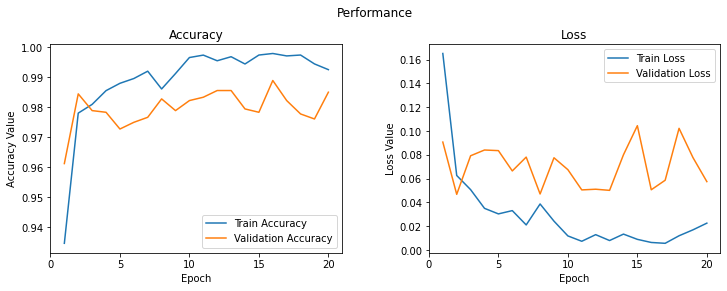

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
title = fig.suptitle('Performance', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, epochs+1))

ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
legend1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
legend2 = ax2.legend(loc="best")

## Test Set Prediction

In [24]:
@torch.no_grad()

def test_predict(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    results = model.test_prediction(outputs)
    
    print('test_loss: {:.4f}, test_acc: {:.4f}'.format(results['test_loss'], results['test_acc']))

    return results['test_preds'], results['test_labels']

test_dataset = ImageFolder(data_dir+'test', transform=tt.Compose([tt.Resize(255),
                                                              tt.CenterCrop(224),
                                                              tt.RandomHorizontalFlip(),
                                                              tt.RandomRotation(10),
                                                              tt.RandomGrayscale(),
                                                              tt.RandomAffine(translate=(0.05, 0.05), degrees=0),
                                                              tt.ToTensor(),
                                                              tt.Normalize(mean=[0.485, 0.456, 0.406],
                                                                           std=[0.229, 0.224, 0.225],
                                                                           inplace=True)
                                                              ]))

In [25]:
test_dl = DataLoader(test_dataset)
preds, labels = test_predict(model, test_dl)

test_loss: 0.7151, test_acc: 0.8542


## Model Evaluation Metrics
Since there is a huge data class imbalance, it is better to look at the F1 score than the accuracy.

<Figure size 432x288 with 0 Axes>

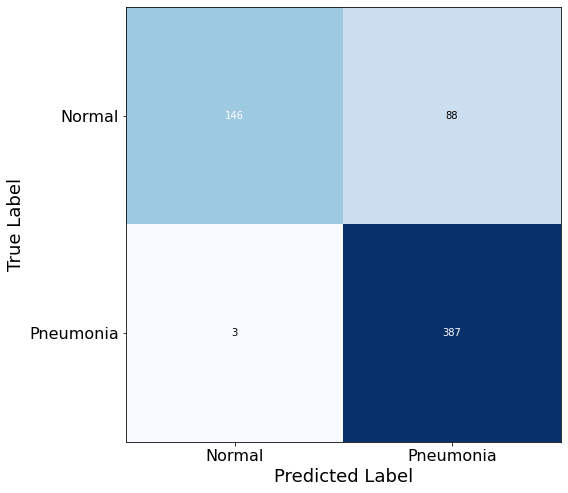

In [26]:
cm = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [27]:
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.85
Recall of the model is 0.99
Precision of the model is 0.81
F1 Score of the model is 0.89


## Comparing with Actual Labels

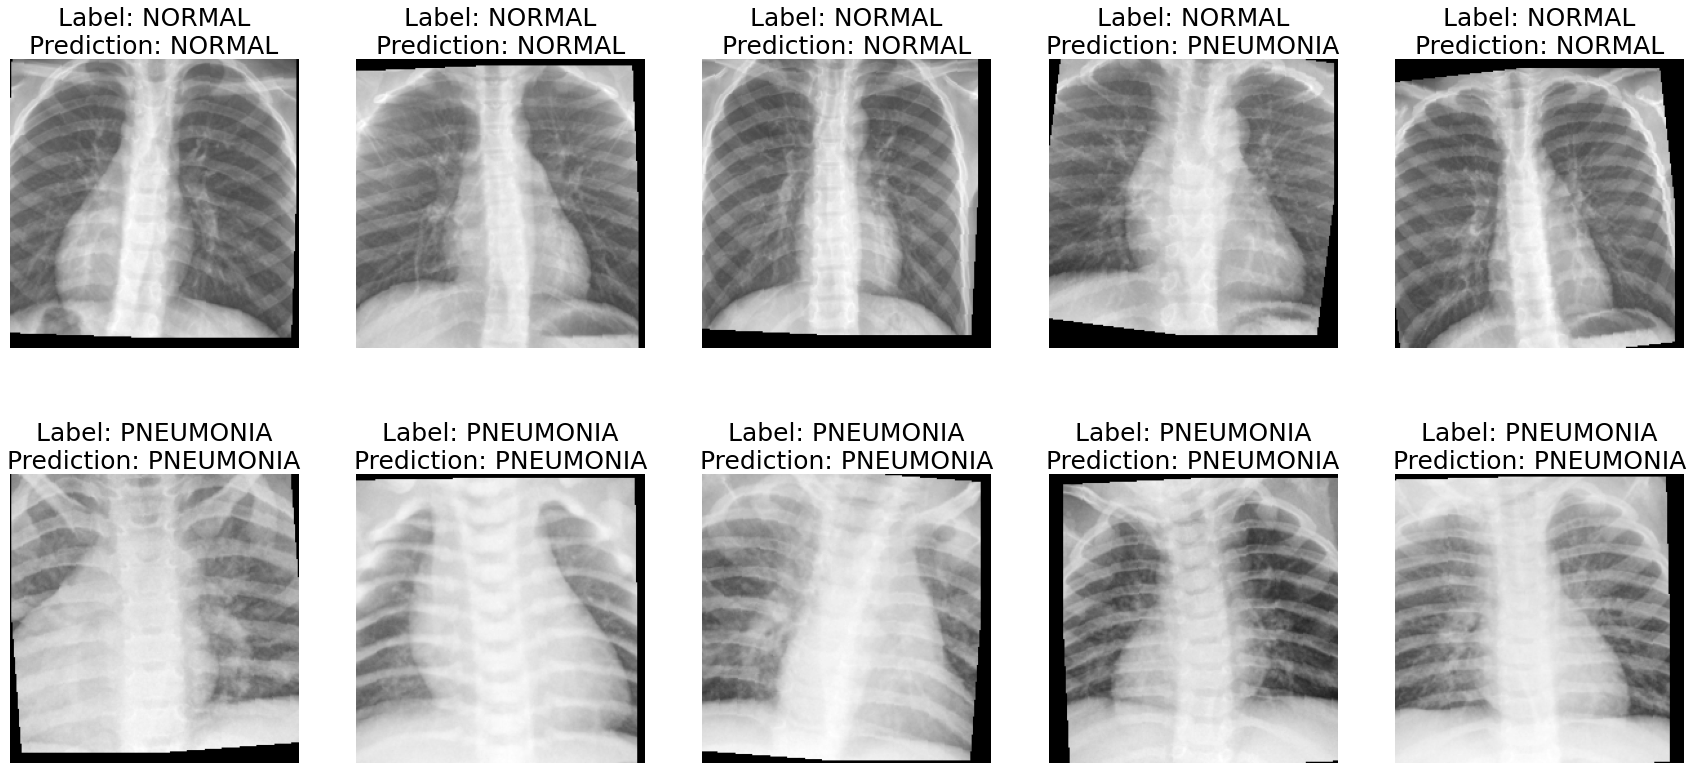

In [28]:
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=500, stop=505, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(test_dataset.classes[label], 
                                    test_dataset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')

## Conclusion
In conclusion, the model performed well, predicting most of the pneumonia images. However, some false positives can also increase the cost of healthcare or lead to panic. Better performance can be achieved by tuning the hyperparameters. Once the best model is found, the practical use of machine learning in pneumonia/COVID-19 detection can be considered.